In [203]:
import math
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [230]:
class Value:
    """ A single scalar value that supports automatic differentiation. """

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

        
        
    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other - 1)) * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def sigmoid(self):
        x = self.data
        s = 1 / (1 + math.exp(-x))
        out = Value(s, (self,), 'sigmoid')

        def _backward():
            self.grad += out.data * (1 - out.data) * out.grad
        out._backward = _backward

        return out

    def backward(self):
        # Reset gradients before the backward pass
        self.zero_grad()

        # Topological sort
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # Go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1.0
        for v in reversed(topo):
            v._backward()

    def zero_grad(self):
        # Topological sort to reset the gradients
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # Reset the gradient for each node
        for v in topo:
            v.grad = 0

    def sgd_step(self, learning_rate):
        # Topological sort to update the values
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # Update the value for each node using SGD
        for v in topo:
            if v._op:  # If it's an operation node, skip updating
                continue
            v.data -= learning_rate * v.grad

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

In [231]:
#Add Graphviz to the PATH Environment Variable
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [232]:
def train(inputs, weights, biases, target, epochs, learning_rate):
    for epoch in range(epochs):
        # Forward pass
        x1, x2 = inputs
        w1, w2, w3, w4 = weights
        b1, b2 = biases

        x1w1 = x1 * w1
        x2w2 = x2 * w2
        h1 = x1w1 + x2w2 + b1
        h1_sigmoid = h1.sigmoid()
        
        h1w3 = h1_sigmoid * w3
        h1w4 = h1_sigmoid * w4
        n = h1w3 + h1w4 + b2
        o = n.sigmoid()

        # Loss function (squared error)
        loss = (o - target) ** 2

        # Backward pass
        loss.backward()

        # Perform SGD update
        loss.sgd_step(learning_rate)

        # Print values and gradients every 5 epochs
        if epoch % 25 == 0:
            print(f"Epoch [{epoch}/{epochs}]")
            print(f"Loss: {loss.data:.4f}")
            print(f"Gradients - x1: {x1.grad:.4f}, w1: {w1.grad:.4f}, x2: {x2.grad:.4f}, w2: {w2.grad:.4f}, b1: {b1.grad:.4f}")
            print(f"w3: {w3.grad:.4f}, w4: {w4.grad:.4f}, b2: {b2.grad:.4f}")
            print(f"Values - x1: {x1.data:.4f}, w1: {w1.data:.4f}, x2: {x2.data:.4f}, w2: {w2.data:.4f}, b1: {b1.data:.4f}")
            print(f"w3: {w3.data:.4f}, w4: {w4.data:.4f}, b2: {b2.data:.4f}")
            print("\n")

In [233]:
# Initialize variables
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b1 = Value(6.8813735870195432, label='b1')
w3 = Value(-2.0, label='w3')
w4 = Value(3.0, label='w4')
b2 = Value(4.0, label='b2')

In [234]:
inputs = [x1, x2]
weights = [w1, w2, w3, w4]
biases = [b1, b2]

In [235]:
# Target value
target = Value(1.0)

In [236]:
# Train the model
train(inputs, weights, biases, target, epochs=100, learning_rate=0.01)

Epoch [0/100]
Loss: 0.0001
Gradients - x1: 0.0001, w1: -0.0001, x2: -0.0000, w2: 0.0000, b1: -0.0000
w3: -0.0001, w4: -0.0001, b2: -0.0002
Values - x1: 2.0000, w1: -3.0000, x2: 0.0000, w2: 1.0000, b1: 6.8814
w3: -2.0000, w4: 3.0000, b2: 4.0000


Epoch [25/100]
Loss: 0.0000
Gradients - x1: 0.0001, w1: -0.0000, x2: -0.0000, w2: -0.0000, b1: -0.0000
w3: -0.0001, w4: -0.0001, b2: -0.0001
Values - x1: 2.0000, w1: -3.0000, x2: 0.0000, w2: 1.0000, b1: 6.8814
w3: -2.0000, w4: 3.0000, b2: 4.0000


Epoch [50/100]
Loss: 0.0000
Gradients - x1: 0.0000, w1: -0.0000, x2: -0.0000, w2: -0.0000, b1: -0.0000
w3: -0.0000, w4: -0.0000, b2: -0.0001
Values - x1: 2.0000, w1: -3.0000, x2: 0.0000, w2: 1.0000, b1: 6.8814
w3: -2.0000, w4: 3.0000, b2: 4.0001


Epoch [75/100]
Loss: 0.0000
Gradients - x1: 0.0000, w1: -0.0000, x2: -0.0000, w2: -0.0000, b1: -0.0000
w3: -0.0000, w4: -0.0000, b2: -0.0000
Values - x1: 2.0000, w1: -3.0000, x2: 0.0000, w2: 1.0000, b1: 6.8814
w3: -2.0000, w4: 3.0000, b2: 4.0001




In [237]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define a simple neural network
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(2, 1)  # Input layer to hidden layer
        self.fc2 = nn.Linear(1, 1)  # Hidden layer to output layer

        # Manually set the weights and biases to match the custom implementation
        with torch.no_grad():
            self.fc1.weight = nn.Parameter(torch.tensor([[-3.0, 1.0]]))
            self.fc1.bias = nn.Parameter(torch.tensor([6.8813735870195432]))
            self.fc2.weight = nn.Parameter(torch.tensor([[-2.0]]))
            self.fc2.bias = nn.Parameter(torch.tensor([4.0]))

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Initialize the network, loss function, and optimizer
net = SimpleNet()
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

# Define the input and target
inputs = torch.tensor([[2.0, 0.0]])
target = torch.tensor([[1.0]])

# Training loop
for epoch in range(100):
    # Zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = net(inputs)
    loss = criterion(outputs, target)

    # Backward pass
    loss.backward()
    
    # Perform SGD update
    optimizer.step()

    # Print values and gradients every 5 epochs
    if epoch % 5 == 0:
        print(f"Epoch [{epoch}/100]")
        print(f"Loss: {loss.item():.4f}")
        for name, param in net.named_parameters():
            if param.requires_grad:
                print(f"{name}.grad: {param.grad}")
                print(f"{name}: {param.data}")

        print("\n")

# Extract final gradients and values for comparison
pytorch_grads = {name: param.grad.clone().detach().numpy() for name, param in net.named_parameters()}
pytorch_params = {name: param.clone().detach().numpy() for name, param in net.named_parameters()}


Epoch [0/100]
Loss: 0.0049
fc1.weight.grad: tensor([[0.0076, 0.0000]])
fc1.weight: tensor([[-3.0001,  1.0000]])
fc1.bias.grad: tensor([0.0038])
fc1.bias: tensor([6.8813])
fc2.weight.grad: tensor([[-0.0065]])
fc2.weight: tensor([[-1.9999]])
fc2.bias.grad: tensor([-0.0091])
fc2.bias: tensor([4.0001])


Epoch [5/100]
Loss: 0.0049
fc1.weight.grad: tensor([[0.0075, 0.0000]])
fc1.weight: tensor([[-3.0005,  1.0000]])
fc1.bias.grad: tensor([0.0038])
fc1.bias: tensor([6.8811])
fc2.weight.grad: tensor([[-0.0064]])
fc2.weight: tensor([[-1.9996]])
fc2.bias.grad: tensor([-0.0091])
fc2.bias: tensor([4.0005])


Epoch [10/100]
Loss: 0.0049
fc1.weight.grad: tensor([[0.0075, 0.0000]])
fc1.weight: tensor([[-3.0008,  1.0000]])
fc1.bias.grad: tensor([0.0038])
fc1.bias: tensor([6.8810])
fc2.weight.grad: tensor([[-0.0064]])
fc2.weight: tensor([[-1.9993]])
fc2.bias.grad: tensor([-0.0091])
fc2.bias: tensor([4.0010])


Epoch [15/100]
Loss: 0.0049
fc1.weight.grad: tensor([[0.0075, 0.0000]])
fc1.weight: tensor([[

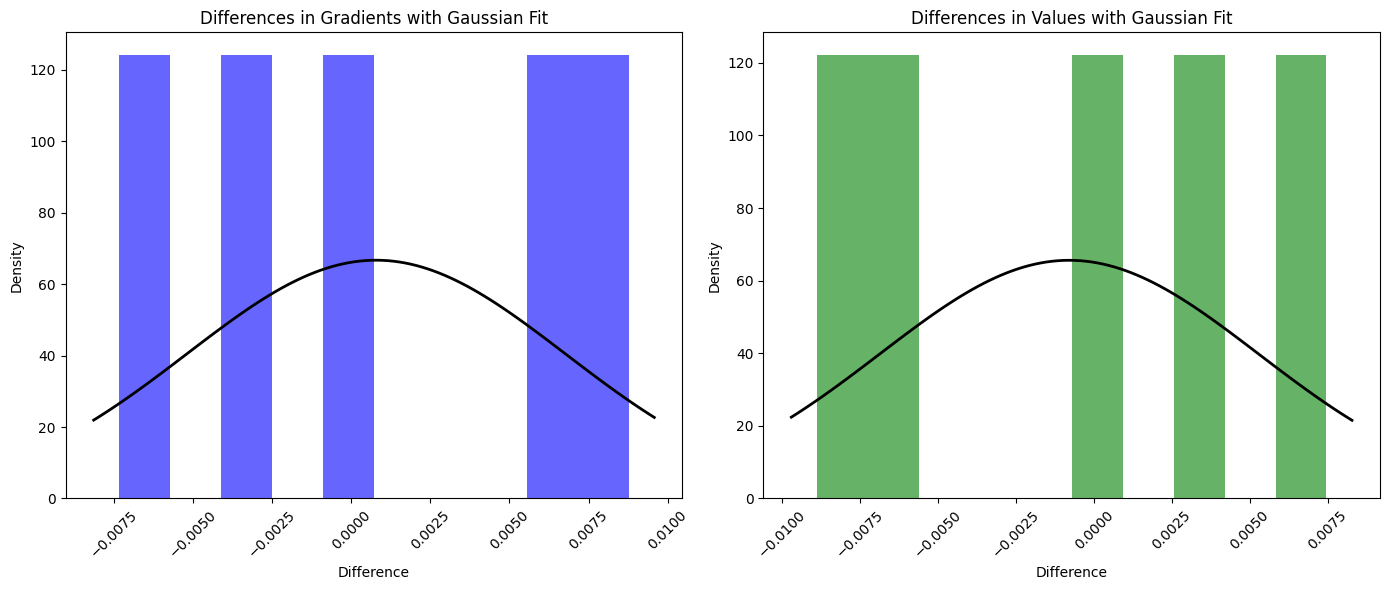

Differences in Gradients: {'w1': -0.007325375246093075, 'w2': -6.321056695157857e-11, 'b1': -0.0036626877178619443, 'w3': 0.006168603368168176, 'b2': 0.008771321083037633}
Standard Deviation of Gradient Differences: 0.005982319000641854

Differences in Values: {'w1': 0.007466459614272392, 'w2': 1.0030154484752529e-10, 'b1': 0.003733292311297376, 'w3': -0.0062690544159409445, 'b2': -0.008889497474923402}
Standard Deviation of Value Differences: 0.006080711800531861


In [243]:
# Custom Value class gradients and values
custom_grads = {
    "w1": w1.grad,
    "w2": w2.grad,
    "b1": b1.grad,
    "w3": w3.grad,
    "w4": w4.grad,
    "b2": b2.grad
}

custom_values = {
    "w1": w1.data,
    "w2": w2.data,
    "b1": b1.data,
    "w3": w3.data,
    "w4": w4.data,
    "b2": b2.data
}

# Mapping to correct PyTorch parameters
pytorch_grads_mapped = {
    "w1": pytorch_grads["fc1.weight"][0, 0],
    "w2": pytorch_grads["fc1.weight"][0, 1],
    "b1": pytorch_grads["fc1.bias"][0],
    "w3": pytorch_grads["fc2.weight"][0, 0],
    "w4": 0,  # Not directly comparable, since fc2 only has one input weight in PyTorch
    "b2": pytorch_grads["fc2.bias"][0]
}

pytorch_values_mapped = {
    "w1": pytorch_params["fc1.weight"][0, 0],
    "w2": pytorch_params["fc1.weight"][0, 1],
    "b1": pytorch_params["fc1.bias"][0],
    "w3": pytorch_params["fc2.weight"][0, 0],
    "w4": 0,  # Not directly comparable, since fc2 only has one input weight in PyTorch
    "b2": pytorch_params["fc2.bias"][0]
}

# Calculate differences
grad_diffs = {name: custom_grads[name] - pytorch_grads_mapped[name] for name in custom_grads if name != 'w4'}
value_diffs = {name: custom_values[name] - pytorch_values_mapped[name] for name in custom_values if name != 'w4'}

# Convert to arrays for easier plotting
grad_diffs_arr = np.array(list(grad_diffs.values()))
value_diffs_arr = np.array(list(value_diffs.values()))

# Plot the differences with Gaussian fit
plt.figure(figsize=(14, 6))

# Gradients
plt.subplot(1, 2, 1)
n, bins, patches = plt.hist(grad_diffs_arr, bins=10, density=True, alpha=0.6, color='blue')
mu, std = norm.fit(grad_diffs_arr)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.title('Differences in Gradients with Gaussian Fit')
plt.ylabel('Density')
plt.xlabel('Difference')
plt.xticks(rotation=45)

# Values
plt.subplot(1, 2, 2)
n, bins, patches = plt.hist(value_diffs_arr, bins=10, density=True, alpha=0.6, color='green')
mu, std = norm.fit(value_diffs_arr)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.title('Differences in Values with Gaussian Fit')
plt.ylabel('Density')
plt.xlabel('Difference')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Print the differences and standard deviations
print("Differences in Gradients:", grad_diffs)
print("Standard Deviation of Gradient Differences:", np.std(grad_diffs_arr))
print("\nDifferences in Values:", value_diffs)
print("Standard Deviation of Value Differences:", np.std(value_diffs_arr))
